## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

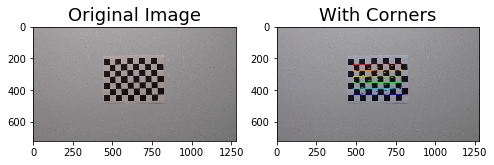

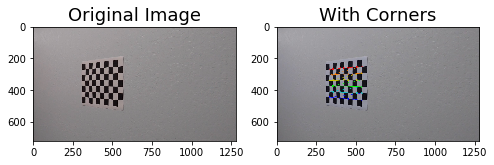

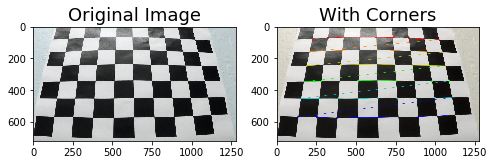

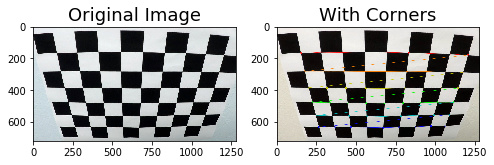

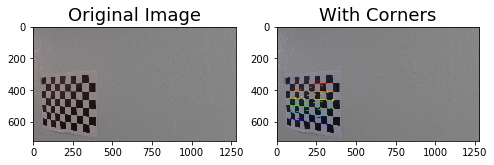

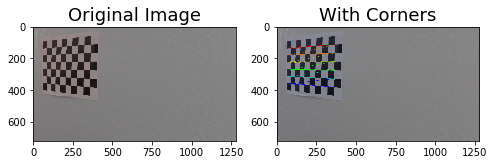

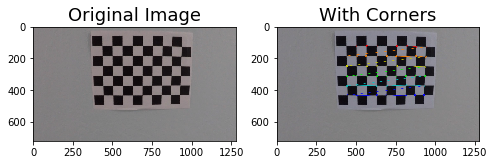

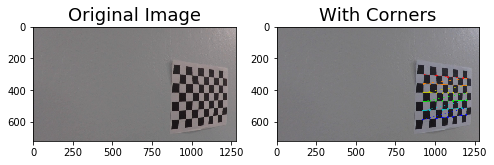

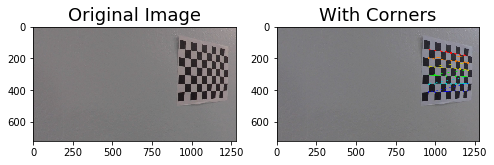

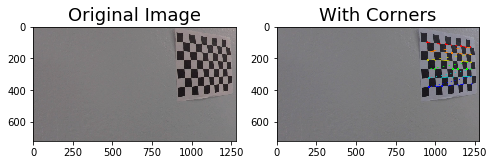

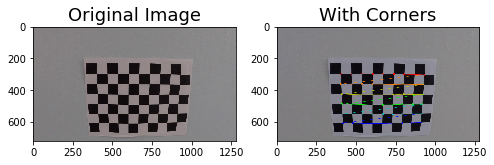

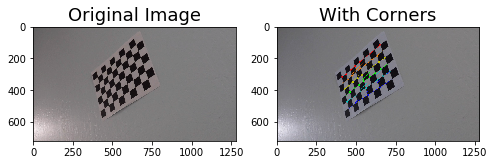

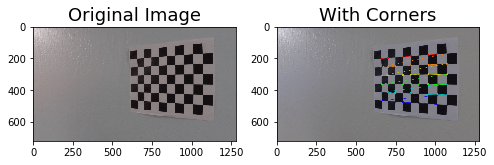

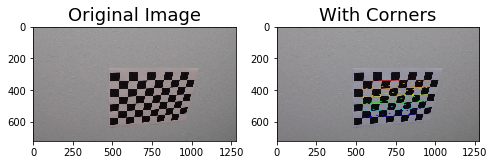

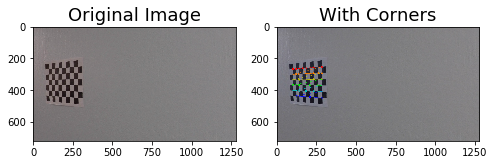

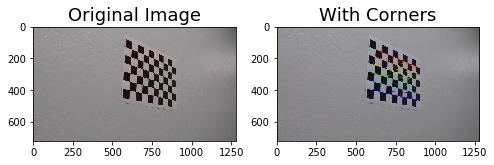

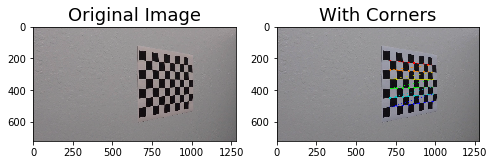

In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
img_size = None
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    offset = 100 # offset for dst points

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

## And so on and so forth...

In [35]:
# For source points I'm grabbing the outer four detected corners
src = np.float32([[461,547], [833,547], [1000,653], [303,653]])
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32([[453,610], [850,610], [850,653], [453,653]])
# # Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [36]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print(img_size)

(1280, 720)


In [37]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= min(thresh)) & (scaled_sobel <= max(thresh))] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [38]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [39]:
def curvature(left_line, right_line):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

#     print (len(left_line.allx*ym_per_pix), len(left_line.allx*xm_per_pix))
    left_y_eval = np.max(left_line.ally)
    right_y_eval = np.max(right_line.ally)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_line.ally*ym_per_pix, left_line.allx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_line.ally*ym_per_pix, right_line.allx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*left_y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*right_y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

left_line = Line()
right_line = Line()

def find_lines(binary_warped):
    global left_line
    global right_line
    
    if not left_line.detected and not right_line.detected:
        left_line.detected = True
        right_line.detected = True
        
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        print(midpoint)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        print (lefty[45], righty[45])

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        #polynomial coefficients for the most recent fit
        left_line.current_fit = left_fit
        #x values for detected line pixels
        left_line.allx = leftx  
        #y values for detected line pixels
        left_line.ally = lefty

        #polynomial coefficients for the most recent fit
        right_line.current_fit = right_fit
        #x values for detected line pixels
        right_line.allx = rightx  
        #y values for detected line pixels
        right_line.ally = righty
        
    else:
        
#         if (len(left_line.recent_xfitted) > 5):
#             left_line.recent_xfitted.pop(0)
#         left_line.recent_xfitted.append(left_line.current_fit)
#         left_line.bestx = np.mean(left_line.recent_xfitted, axis=0)
#         if (len(right_line.recent_xfitted) > 5):
#             right_line.recent_xfitted.pop(0)
#         right_line.recent_xfitted.append(right_line.current_fit)
#         right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_line.current_fit[0]*(nonzeroy**2) + left_line.current_fit[1]*nonzeroy + 
        left_line.current_fit[2] - margin)) & (nonzerox < (left_line.current_fit[0]*(nonzeroy**2) + 
        left_line.current_fit[1]*nonzeroy + left_line.current_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_line.current_fit[0]*(nonzeroy**2) + right_line.current_fit[1]*nonzeroy + 
        right_line.current_fit[2] - margin)) & (nonzerox < (right_line.current_fit[0]*(nonzeroy**2) + 
        right_line.current_fit[1]*nonzeroy + right_line.current_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_line.current_fit = np.polyfit(lefty, leftx, 2)
        left_line.allx = leftx  
        left_line.ally = lefty
        right_line.current_fit = np.polyfit(righty, rightx, 2)
        right_line.allx = rightx  
        right_line.ally = righty
        
    #radius of curvature of the lines in meters
    left_line.radius_of_curvature, right_line.radius_of_curvature = curvature(left_line, right_line)
    
    return left_line, right_line
    #     return nonzerox, nonzeroy, left_lane_inds, right_lane_inds, left_fit, right_fit

In [48]:
example = True
from matplotlib.backends.backend_pdf import PdfPages
import scipy
def process_image(image):
    
    global left_line
    global right_line
    global example
    
    folder = "../output_images/"
    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # result = get_lines(image)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    if example:
        plt.imshow(undist)
        plt.title("undist")
        plt.savefig(folder+"undist.jpg")
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    if example:
        plt.imshow(warped)
        plt.title("warped")
        plt.savefig(folder+"warped.jpg")
    
    ksize = 3
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    if example:
        plt.imshow(gradx)
        plt.title("gradx")
        plt.savefig(folder+"gradx.jpg")
    mag_binary = mag_thresh(warped, sobel_kernel=ksize, mag_thresh=(30, 100))
    if example:
        plt.imshow(mag_binary)
        plt.title("mag_binary")
        plt.savefig(folder+"mag_binary.jpg")
    dir_binary = dir_threshold(warped, sobel_kernel=ksize, thresh=(0.7, 1.3))
    if example:
        plt.imshow(dir_binary)
        plt.title("dir_binary")
        plt.savefig(folder+"dir_binary.jpg")
    hls_binary = hls_select(warped, thresh=(90, 255))
    if example:
        plt.imshow(hls_binary)
        plt.title("hls_binary")
        plt.savefig(folder+"hls_binary.jpg")
    
    binary_warped = np.zeros_like(gradx)
    binary_warped[(gradx == 1 | ((mag_binary == 1) & (dir_binary == 1))) | hls_binary == 1] = 1
    if example:
        plt.imshow(binary_warped)
        plt.title("binary_warped")
        plt.savefig(folder+"binary_warped.jpg")
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    find_lines(binary_warped)
    left_fitx = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
    right_fitx = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2]
        
    
#     # Sanity check
    lane_width_pixels = abs(right_fitx[image.shape[0]-1]-left_fitx[image.shape[0]-1])
#     lane_width_pixels_top = abs(right_fitx[0]-left_fitx[0])
#     lane_width_sanity = abs(lane_width_pixels-lane_width_pixels_top)
    
#     curvature_sanity = abs(left_line.radius_of_curvature-right_line.radius_of_curvature)
    
#     if (len(left_lane.recent_xfitted) == 5):
#         left_lane.recent_xfitted.pop(0)
#     left_lane.recent_xfitted.append(left_fitx)
#     self.bestx = np.mean(left_lane.recent_xfitted)
        
    image_center_x = image.shape[1]/2
    offset = image_center_x-(abs(left_fitx[image.shape[0]-1]+right_fitx[image.shape[0]-1])/2)
    lane_width_meters = 3.7
    lane_width_metersperpixel = lane_width_meters/lane_width_pixels
    offset_meters = offset*lane_width_metersperpixel
    
    side = ""
    if offset_meters <= 0:
        side = "left"
    else:
        side = "right"
        
    # TODO: set offset in lane objet
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    lane_color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    lane_color_warp[left_line.ally, left_line.allx] = [255, 0, 0]
    lane_color_warp[right_line.ally, right_line.allx] = [0, 0, 255]
    if example:
        plt.imshow(lane_color_warp)
        plt.title("lane_color_warp")
        plt.savefig(folder+"lane_color_warp.jpg")
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    if example:
        plt.imshow(color_warp)
        plt.title("color_warp")
        plt.savefig(folder+"color_warp.jpg")
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    newlanecolorwarp = cv2.warpPerspective(lane_color_warp, Minv, (image.shape[1], image.shape[0])) 
    if example:
        plt.imshow(newwarp)
        plt.title("newwarp")
        plt.savefig(folder+"newwarp.jpg")
        plt.imshow(newlanecolorwarp)
        plt.title("newlanecolorwarp")
        plt.savefig(folder+"newlanecolorwarp.jpg")
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(result, 1, newlanecolorwarp, 1, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of Curvature is %.2fkm' % (np.mean([left_line.radius_of_curvature, right_line.radius_of_curvature])/1000), (10,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle is %.2fm %s of center' % (abs(offset_meters),side), (10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    if example:
        plt.imshow(result)
        plt.title("result")
        plt.savefig(folder+"result.jpg")
#     combined_255 = combined*255
    
#     color = cv2.cvtColor(combined_255, cv2.COLOR_GRAY2RGB)
    
#     plt.imshow(result)
#     plt.show()

#     plt.imshow(undist)
#     plt.figure()
#     plt.imshow(warped)
#     plt.show()

    example = False
    
    return result

[MoviePy] >>>> Building video ../output_images/project_video_lanes.mp4
[MoviePy] Writing video ../output_images/project_video_lanes.mp4








  0%|          | 0/1261 [00:00<?, ?it/s]





  0%|          | 1/1261 [00:00<03:17,  6.37it/s]





  0%|          | 2/1261 [00:00<03:17,  6.36it/s]





  0%|          | 3/1261 [00:00<03:14,  6.47it/s]





  0%|          | 4/1261 [00:00<03:11,  6.58it/s]





  0%|          | 5/1261 [00:00<03:09,  6.63it/s]





  0%|          | 6/1261 [00:00<03:07,  6.68it/s]





  1%|          | 7/1261 [00:01<03:07,  6.68it/s]





  1%|          | 8/1261 [00:01<03:09,  6.62it/s]





  1%|          | 9/1261 [00:01<03:11,  6.53it/s]





  1%|          | 10/1261 [00:01<03:10,  6.57it/s]





  1%|          | 11/1261 [00:01<03:09,  6.59it/s]





  1%|          | 12/1261 [00:01<03:11,  6.53it/s]





  1%|          | 13/1261 [00:01<03:13,  6.47it/s]





  1%|          | 14/1261 [00:02<03:14,  6.41it/s]





  1%|          | 15/1261 [00:02<03:14,  6.41it/s]





  1%|▏         | 16/1261 [00:02<03:14,  6.39it/s]





  1%|▏         | 17/1261 [00:02<03:19,  6.24it/s]





  1%|▏         | 18/12

  9%|▉         | 112/1261 [00:17<03:03,  6.26it/s]





  9%|▉         | 113/1261 [00:17<03:04,  6.21it/s]





  9%|▉         | 114/1261 [00:17<03:07,  6.11it/s]





  9%|▉         | 115/1261 [00:17<03:04,  6.21it/s]





  9%|▉         | 116/1261 [00:18<03:03,  6.24it/s]





  9%|▉         | 117/1261 [00:18<03:01,  6.31it/s]





  9%|▉         | 118/1261 [00:18<03:01,  6.28it/s]





  9%|▉         | 119/1261 [00:18<03:02,  6.25it/s]





 10%|▉         | 120/1261 [00:18<03:04,  6.20it/s]





 10%|▉         | 121/1261 [00:18<03:00,  6.33it/s]





 10%|▉         | 122/1261 [00:18<02:55,  6.47it/s]





 10%|▉         | 123/1261 [00:19<02:53,  6.56it/s]





 10%|▉         | 124/1261 [00:19<02:52,  6.60it/s]





 10%|▉         | 125/1261 [00:19<02:50,  6.66it/s]





 10%|▉         | 126/1261 [00:19<02:49,  6.68it/s]





 10%|█         | 127/1261 [00:19<02:49,  6.69it/s]





 10%|█         | 128/1261 [00:19<02:48,  6.71it/s]





 10%|█         | 129/1261 [00:20<02:49,  6.69it/

 18%|█▊        | 222/1261 [00:34<02:46,  6.25it/s]





 18%|█▊        | 223/1261 [00:34<02:45,  6.29it/s]





 18%|█▊        | 224/1261 [00:34<02:43,  6.32it/s]





 18%|█▊        | 225/1261 [00:34<02:46,  6.23it/s]





 18%|█▊        | 226/1261 [00:35<02:44,  6.27it/s]





 18%|█▊        | 227/1261 [00:35<02:44,  6.30it/s]





 18%|█▊        | 228/1261 [00:35<02:41,  6.38it/s]





 18%|█▊        | 229/1261 [00:35<02:48,  6.13it/s]





 18%|█▊        | 230/1261 [00:35<02:43,  6.30it/s]





 18%|█▊        | 231/1261 [00:35<02:42,  6.35it/s]





 18%|█▊        | 232/1261 [00:35<02:38,  6.47it/s]





 18%|█▊        | 233/1261 [00:36<02:38,  6.51it/s]





 19%|█▊        | 234/1261 [00:36<02:37,  6.52it/s]





 19%|█▊        | 235/1261 [00:36<02:41,  6.34it/s]





 19%|█▊        | 236/1261 [00:36<02:39,  6.43it/s]





 19%|█▉        | 237/1261 [00:36<02:37,  6.52it/s]





 19%|█▉        | 238/1261 [00:36<02:35,  6.59it/s]





 19%|█▉        | 239/1261 [00:37<02:34,  6.61it/

 26%|██▋       | 332/1261 [00:51<02:16,  6.82it/s]





 26%|██▋       | 333/1261 [00:51<02:16,  6.82it/s]





 26%|██▋       | 334/1261 [00:51<02:16,  6.77it/s]





 27%|██▋       | 335/1261 [00:51<02:17,  6.74it/s]





 27%|██▋       | 336/1261 [00:51<02:17,  6.72it/s]





 27%|██▋       | 337/1261 [00:51<02:17,  6.72it/s]





 27%|██▋       | 338/1261 [00:52<02:17,  6.70it/s]





 27%|██▋       | 339/1261 [00:52<02:18,  6.67it/s]





 27%|██▋       | 340/1261 [00:52<02:18,  6.66it/s]





 27%|██▋       | 341/1261 [00:52<02:16,  6.73it/s]





 27%|██▋       | 342/1261 [00:52<02:16,  6.73it/s]





 27%|██▋       | 343/1261 [00:52<02:16,  6.74it/s]





 27%|██▋       | 344/1261 [00:52<02:15,  6.77it/s]





 27%|██▋       | 345/1261 [00:53<02:15,  6.78it/s]





 27%|██▋       | 346/1261 [00:53<02:16,  6.72it/s]





 28%|██▊       | 347/1261 [00:53<02:20,  6.49it/s]





 28%|██▊       | 348/1261 [00:53<02:19,  6.52it/s]





 28%|██▊       | 349/1261 [00:53<02:20,  6.48it/

 35%|███▌      | 442/1261 [01:07<02:03,  6.65it/s]





 35%|███▌      | 443/1261 [01:07<02:04,  6.56it/s]





 35%|███▌      | 444/1261 [01:08<02:04,  6.58it/s]





 35%|███▌      | 445/1261 [01:08<02:03,  6.60it/s]





 35%|███▌      | 446/1261 [01:08<02:02,  6.64it/s]





 35%|███▌      | 447/1261 [01:08<02:02,  6.66it/s]





 36%|███▌      | 448/1261 [01:08<02:01,  6.67it/s]





 36%|███▌      | 449/1261 [01:08<02:00,  6.72it/s]





 36%|███▌      | 450/1261 [01:08<02:00,  6.73it/s]





 36%|███▌      | 451/1261 [01:09<01:59,  6.76it/s]





 36%|███▌      | 452/1261 [01:09<01:59,  6.79it/s]





 36%|███▌      | 453/1261 [01:09<01:59,  6.77it/s]





 36%|███▌      | 454/1261 [01:09<01:59,  6.76it/s]





 36%|███▌      | 455/1261 [01:09<02:01,  6.61it/s]





 36%|███▌      | 456/1261 [01:09<02:02,  6.57it/s]





 36%|███▌      | 457/1261 [01:09<02:00,  6.65it/s]





 36%|███▋      | 458/1261 [01:10<02:00,  6.64it/s]





 36%|███▋      | 459/1261 [01:10<02:00,  6.68it/

 44%|████▍     | 552/1261 [01:24<01:52,  6.32it/s]





 44%|████▍     | 553/1261 [01:24<01:52,  6.29it/s]





 44%|████▍     | 554/1261 [01:25<01:52,  6.26it/s]





 44%|████▍     | 555/1261 [01:25<01:52,  6.28it/s]





 44%|████▍     | 556/1261 [01:25<01:51,  6.35it/s]





 44%|████▍     | 557/1261 [01:25<01:50,  6.37it/s]





 44%|████▍     | 558/1261 [01:25<01:50,  6.34it/s]





 44%|████▍     | 559/1261 [01:25<01:50,  6.36it/s]





 44%|████▍     | 560/1261 [01:26<01:50,  6.33it/s]





 44%|████▍     | 561/1261 [01:26<01:50,  6.31it/s]





 45%|████▍     | 562/1261 [01:26<01:50,  6.30it/s]





 45%|████▍     | 563/1261 [01:26<01:49,  6.35it/s]





 45%|████▍     | 564/1261 [01:26<01:48,  6.41it/s]





 45%|████▍     | 565/1261 [01:26<01:47,  6.49it/s]





 45%|████▍     | 566/1261 [01:27<01:45,  6.57it/s]





 45%|████▍     | 567/1261 [01:27<01:44,  6.63it/s]





 45%|████▌     | 568/1261 [01:27<01:44,  6.65it/s]





 45%|████▌     | 569/1261 [01:27<01:43,  6.67it/

 52%|█████▏    | 662/1261 [01:41<01:28,  6.73it/s]





 53%|█████▎    | 663/1261 [01:41<01:28,  6.79it/s]





 53%|█████▎    | 664/1261 [01:42<01:26,  6.88it/s]





 53%|█████▎    | 665/1261 [01:42<01:27,  6.80it/s]





 53%|█████▎    | 666/1261 [01:42<01:26,  6.84it/s]





 53%|█████▎    | 667/1261 [01:42<01:28,  6.73it/s]





 53%|█████▎    | 668/1261 [01:42<01:28,  6.69it/s]





 53%|█████▎    | 669/1261 [01:42<01:27,  6.73it/s]





 53%|█████▎    | 670/1261 [01:42<01:26,  6.81it/s]





 53%|█████▎    | 671/1261 [01:43<01:26,  6.82it/s]





 53%|█████▎    | 672/1261 [01:43<01:26,  6.84it/s]





 53%|█████▎    | 673/1261 [01:43<01:25,  6.88it/s]





 53%|█████▎    | 674/1261 [01:43<01:25,  6.87it/s]





 54%|█████▎    | 675/1261 [01:43<01:25,  6.82it/s]





 54%|█████▎    | 676/1261 [01:43<01:24,  6.89it/s]





 54%|█████▎    | 677/1261 [01:43<01:23,  6.98it/s]





 54%|█████▍    | 678/1261 [01:44<01:22,  7.05it/s]





 54%|█████▍    | 679/1261 [01:44<01:23,  7.00it/

 61%|██████    | 772/1261 [01:57<01:11,  6.80it/s]





 61%|██████▏   | 773/1261 [01:58<01:11,  6.84it/s]





 61%|██████▏   | 774/1261 [01:58<01:10,  6.88it/s]





 61%|██████▏   | 775/1261 [01:58<01:10,  6.88it/s]





 62%|██████▏   | 776/1261 [01:58<01:10,  6.85it/s]





 62%|██████▏   | 777/1261 [01:58<01:10,  6.84it/s]





 62%|██████▏   | 778/1261 [01:58<01:10,  6.81it/s]





 62%|██████▏   | 779/1261 [01:58<01:11,  6.71it/s]





 62%|██████▏   | 780/1261 [01:59<01:11,  6.68it/s]





 62%|██████▏   | 781/1261 [01:59<01:11,  6.68it/s]





 62%|██████▏   | 782/1261 [01:59<01:11,  6.71it/s]





 62%|██████▏   | 783/1261 [01:59<01:11,  6.73it/s]





 62%|██████▏   | 784/1261 [01:59<01:11,  6.67it/s]





 62%|██████▏   | 785/1261 [01:59<01:10,  6.77it/s]





 62%|██████▏   | 786/1261 [02:00<01:09,  6.83it/s]





 62%|██████▏   | 787/1261 [02:00<01:08,  6.89it/s]





 62%|██████▏   | 788/1261 [02:00<01:08,  6.94it/s]





 63%|██████▎   | 789/1261 [02:00<01:08,  6.88it/

 70%|██████▉   | 882/1261 [02:13<00:58,  6.49it/s]





 70%|███████   | 883/1261 [02:14<00:58,  6.45it/s]





 70%|███████   | 884/1261 [02:14<00:57,  6.51it/s]





 70%|███████   | 885/1261 [02:14<00:57,  6.50it/s]





 70%|███████   | 886/1261 [02:14<00:57,  6.57it/s]





 70%|███████   | 887/1261 [02:14<00:56,  6.61it/s]





 70%|███████   | 888/1261 [02:14<00:56,  6.65it/s]





 70%|███████   | 889/1261 [02:15<00:55,  6.71it/s]





 71%|███████   | 890/1261 [02:15<00:55,  6.71it/s]





 71%|███████   | 891/1261 [02:15<00:54,  6.74it/s]





 71%|███████   | 892/1261 [02:15<00:55,  6.68it/s]





 71%|███████   | 893/1261 [02:15<00:55,  6.68it/s]





 71%|███████   | 894/1261 [02:15<00:54,  6.71it/s]





 71%|███████   | 895/1261 [02:15<00:54,  6.74it/s]





 71%|███████   | 896/1261 [02:16<00:54,  6.74it/s]





 71%|███████   | 897/1261 [02:16<00:54,  6.67it/s]





 71%|███████   | 898/1261 [02:16<00:55,  6.58it/s]





 71%|███████▏  | 899/1261 [02:16<00:55,  6.50it/

 79%|███████▊  | 992/1261 [02:30<00:44,  6.05it/s]





 79%|███████▊  | 993/1261 [02:30<00:44,  6.04it/s]





 79%|███████▉  | 994/1261 [02:31<00:43,  6.08it/s]





 79%|███████▉  | 995/1261 [02:31<00:43,  6.12it/s]





 79%|███████▉  | 996/1261 [02:31<00:43,  6.10it/s]





 79%|███████▉  | 997/1261 [02:31<00:43,  6.06it/s]





 79%|███████▉  | 998/1261 [02:31<00:43,  6.00it/s]





 79%|███████▉  | 999/1261 [02:31<00:43,  6.03it/s]





 79%|███████▉  | 1000/1261 [02:32<00:42,  6.12it/s]





 79%|███████▉  | 1001/1261 [02:32<00:42,  6.19it/s]





 79%|███████▉  | 1002/1261 [02:32<00:42,  6.15it/s]





 80%|███████▉  | 1003/1261 [02:32<00:42,  6.07it/s]





 80%|███████▉  | 1004/1261 [02:32<00:43,  5.97it/s]





 80%|███████▉  | 1005/1261 [02:32<00:42,  5.97it/s]





 80%|███████▉  | 1006/1261 [02:33<00:42,  6.07it/s]





 80%|███████▉  | 1007/1261 [02:33<00:41,  6.15it/s]





 80%|███████▉  | 1008/1261 [02:33<00:41,  6.10it/s]





 80%|████████  | 1009/1261 [02:33<00:41

 87%|████████▋ | 1101/1261 [02:47<00:23,  6.83it/s]





 87%|████████▋ | 1102/1261 [02:47<00:23,  6.82it/s]





 87%|████████▋ | 1103/1261 [02:48<00:23,  6.73it/s]





 88%|████████▊ | 1104/1261 [02:48<00:23,  6.79it/s]





 88%|████████▊ | 1105/1261 [02:48<00:23,  6.76it/s]





 88%|████████▊ | 1106/1261 [02:48<00:22,  6.77it/s]





 88%|████████▊ | 1107/1261 [02:48<00:22,  6.77it/s]





 88%|████████▊ | 1108/1261 [02:48<00:22,  6.83it/s]





 88%|████████▊ | 1109/1261 [02:48<00:22,  6.91it/s]





 88%|████████▊ | 1110/1261 [02:49<00:21,  6.87it/s]





 88%|████████▊ | 1111/1261 [02:49<00:21,  6.90it/s]





 88%|████████▊ | 1112/1261 [02:49<00:21,  6.91it/s]





 88%|████████▊ | 1113/1261 [02:49<00:21,  6.84it/s]





 88%|████████▊ | 1114/1261 [02:49<00:21,  6.75it/s]





 88%|████████▊ | 1115/1261 [02:49<00:21,  6.74it/s]





 89%|████████▊ | 1116/1261 [02:49<00:21,  6.73it/s]





 89%|████████▊ | 1117/1261 [02:50<00:21,  6.77it/s]





 89%|████████▊ | 1118/1261 [02:

 96%|█████████▌| 1210/1261 [03:04<00:07,  6.58it/s]





 96%|█████████▌| 1211/1261 [03:04<00:07,  6.49it/s]





 96%|█████████▌| 1212/1261 [03:04<00:07,  6.48it/s]





 96%|█████████▌| 1213/1261 [03:04<00:07,  6.50it/s]





 96%|█████████▋| 1214/1261 [03:04<00:07,  6.54it/s]





 96%|█████████▋| 1215/1261 [03:04<00:07,  6.56it/s]





 96%|█████████▋| 1216/1261 [03:05<00:06,  6.57it/s]





 97%|█████████▋| 1217/1261 [03:05<00:06,  6.56it/s]





 97%|█████████▋| 1218/1261 [03:05<00:06,  6.57it/s]





 97%|█████████▋| 1219/1261 [03:05<00:06,  6.57it/s]





 97%|█████████▋| 1220/1261 [03:05<00:06,  6.49it/s]





 97%|█████████▋| 1221/1261 [03:05<00:06,  6.47it/s]





 97%|█████████▋| 1222/1261 [03:05<00:05,  6.54it/s]





 97%|█████████▋| 1223/1261 [03:06<00:05,  6.58it/s]





 97%|█████████▋| 1224/1261 [03:06<00:05,  6.50it/s]





 97%|█████████▋| 1225/1261 [03:06<00:05,  6.47it/s]





 97%|█████████▋| 1226/1261 [03:06<00:05,  6.50it/s]





 97%|█████████▋| 1227/1261 [03:

[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/project_video_lanes.mp4 



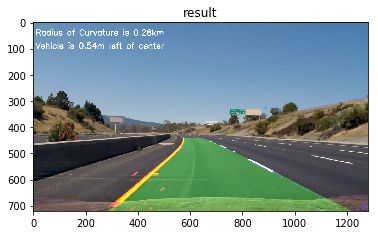

In [49]:
undist_output = '../output_images/project_video_lanes.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
clip1_undist = clip1.fl_image(process_image) #NOTE: this function expects color images!!
clip1_undist.write_videofile(undist_output, audio=False)

# undist_output = '../challenge_video_lanes.mp4'
# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("../challenge_video.mp4")
# clip1_undist = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# clip1_undist.write_videofile(undist_output, audio=False)

# undist_output = '../harder_challenge_video_lanes.mp4'
# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# clip1 = VideoFileClip("../harder_challenge_video.mp4")
# clip1_undist = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# clip1_undist.write_videofile(undist_output, audio=False)